This script shows how to do basic inference tasks on pretrained models.

Pretrained models and the needed additional data can be found here: https://www.dropbox.com/sh/7097vgvdai4pv2c/AABi2OJwzjMVvMC2Q_jiFQF7a?dl=0

To get this running in a standard python3 enviroment the following has to be installed: https://docs.google.com/document/d/1Ce2V8FvyK9VRGkPuKjXziafwyjzAoflAVbrqdcl-CQg/edit?usp=sharing 

## Imports

In [64]:
%matplotlib inline
# General imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import time
from datetime import datetime

# Torch imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Model imports
from torchvision.models import resnet
oldResNet = resnet.ResNet

from skimage import transform as sk_trafo

# for Dimitri data
from plyfile import PlyData, PlyElement
import lz4framed
from glob import glob
import os
import io
import csv

# pose processing
from math import sqrt

# data massaging
from sklearn import preprocessing
import pickle

## Initalization

In [65]:
# Number of outputs of the network, currently 4 for the quaternions and 3 for the location vector
# This should just stay constant
num_output_regressors = 3+4

print_rate = 20

# use the GPU if available
if torch.cuda.is_available():
    device_to_use = torch.device('cuda')
else:
    device_to_use = torch.device('cpu')

device_to_use

device(type='cuda')

In [66]:
# Apply a patch to allow reading ply-data from memory.
# Create the patched function.
def patched_read(self, stream, text, byte_order):
    '''
    Read the actual data from a PLY file.

    '''
    dtype = self.dtype(byte_order)
    if text:
        self._read_txt(stream)
    elif hasattr(stream, 'fileno') and not self._have_list:
        # Loading the data is straightforward.  We will memory map
        # the file in copy-on-write mode.
        num_bytes = self.count * dtype.itemsize
        offset = stream.tell()
        stream.seek(0, 2)
        max_bytes = stream.tell() - offset
        if max_bytes < num_bytes:
            raise PlyElementParseError("early end-of-file", self,
                                       max_bytes // dtype.itemsize)
        if isinstance(stream, io.BytesIO):
            stream.seek(0)
            self._data = np.frombuffer(stream.read(),dtype=dtype,offset=offset,count=self.count)
        else:
            self._data = np.memmap(stream, dtype, 'c', offset, self.count)
        # Fix stream position
        stream.seek(offset + self.count * dtype.itemsize)
    else:
        # A simple load is impossible.
        self._read_bin(stream, byte_order)

    self._check_sanity()


# replace the _read function internal to PlyElement
PlyElement._read = patched_read

In [67]:
# Prepare a patched ResNet class containing an additional dropout layer

# Copied from: https://github.com/pytorch/vision/blob/21153802a3086558e9385788956b0f2808b50e51/torchvision/models/resnet.py
# Added a dropout layer in front of the last FC-layer
# Dropouts in the conv-layers are not recomended and interfere with batch-noarmalization
# See: https://towardsdatascience.com/dont-use-dropout-in-convolutional-networks-81486c823c16
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, dropout_p=0.0):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # begin edit1
        self.dropout = nn.Dropout(p=dropout_p)
        # end edit1
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # begin edit2
        x = self.dropout(x)
        # end edit2
        x = self.fc(x)

        return x

# Not contained in the current version of trochvision?
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

## Functions for inferencing

In [68]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __init__(self, device):
        assert isinstance(device, torch.device)
        self.device = device

    def __call__(self, sample):
        im_xyz, pose = sample['image_xyz'], sample['pose']
        data_list = [im_xyz, pose]

        # swap color axis, because:
        # numpy image: H x W x C
        # torch image: C X H X W
        data_list[0] = data_list[0].transpose((2, 0, 1))
        
        # apply transformations, that are the same for all parts
        for i in range(len(data_list)):
            # convert numpy arrays to torch (float32) tensors
            data_list[i] = torch.from_numpy(data_list[i]).float()
            # now transfer them to the correct divice
            data_list[i] = data_list[i].to(self.device)
        
        return {'image_xyz': data_list[0],
                'pose': data_list[1]}

class Crop(object):
    """Crops the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        im_xyz, pose = sample['image_xyz'], sample['pose']

        x, y = im_xyz.shape[:2]
 
        if isinstance(self.output_size, int):
            cropx, cropy = self.output_size, self.output_size
        else:
            cropx, cropy = self.output_size
            
        # calculate start and stop
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)

        im_xyz = im_xyz[startx:startx+cropx, starty:starty+cropy, :]
        
        return {'image_xyz': im_xyz,
                'pose': pose}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        im_xyz, pose = sample['image_xyz'], sample['pose']

        h, w = im_xyz.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        im_xyz = sk_trafo.resize(im_xyz, (new_h, new_w), mode='reflect', anti_aliasing=True)
        
        return {'image_xyz': im_xyz,
                'pose': pose}

def get_tensor_from_ply_file(ply_file_name, trafos=transforms.Compose([Crop((224, 224)), ToTensor(torch.device('cpu'))])):
    # basically do what the DimitriDataset class does, but now only for one file

    # get the image data
    plydata = PlyData.read(ply_file_name)
    # save it into an empty np array and make sure that it's the correct shape
    im_xyz = np.empty((320, 240, 3))
    directions = ('x' , 'y', 'z')
    for i in range(3):
        # bring the data into the correct shape
        # and convert the nan's to 0
        data = plydata['vertex'][directions[i]].reshape((320, 240))
        data = np.nan_to_num(data)
        im_xyz[..., i] = data

    # get some ouput data, that is just here to be able to reuse our transformations
    unused_output_data = np.ones(num_output_regressors)

    # apply the same transformations as the DimitriDataset class would
    sample = {"image_xyz": im_xyz, "pose": unused_output_data}
    sample = trafos(sample)

    # pretend we had a batch of 1
    sample['image_xyz'] = sample['image_xyz'].reshape([1, *sample['image_xyz'].shape])
    
    return sample['image_xyz']

def inference_image_tensor(image_tensor, model, output_scaler, normalize_quaternions=True):
    # now do the actual inferencing
    output_raw = model(image_tensor)
    #if device_to_use == torch.device('cpu'):
    #    output_raw = output_raw.detach().numpy()
    #else:
    output_raw = output_raw.cpu().detach().numpy()
    output_scaled = output_scaler.inverse_transform(output_raw)[0]

    pos, quat = output_scaled[:3], output_scaled[3:]
    
    # if the user wishes, normalize the quaternions (so that they make more sense)
    if normalize_quaternions:
        quat /= np.linalg.norm(quat)
    
    return pos, quat


def read_torch_and_misc_data_from_disk(model_base_file_name):
    # do or revert patching of the ResNet class
    if "dropout_p" in model_base_file_name:
        resnet.conv1x1 = conv1x1
        resnet.ResNet = ResNet
    else:
        resnet.ResNet = oldResNet
    
    # read in the .pkl file
    pkl_file = model_base_file_name + "_misc.pkl"

    if not os.path.isfile(pkl_file):
        msg = "Please check the model_base_file_name. The misc file could not be found at: {}"
        raise RuntimeError(msg.format(pkl_file))

    with open(pkl_file, 'rb') as f:
        misc_data = pickle.load(f)
    
    
    # read in the data from pytorch
    model_file = model_base_file_name + "_torch_state_dict.tar"

    if not os.path.isfile(model_file):
        msg = "Please check the model_base_file_name and your files. The state_dict file could not be found at: {}"
        raise RuntimeError(msg.format(model_file))

    if device_to_use == torch.device('cpu'):
        torch_data = torch.load(model_file, map_location='cpu')
    else:
        torch_data = torch.load(model_file)
        
    return misc_data, torch_data

# Conversion from a 3x3 rotation matrix to a quaternion
# as defined here: http://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
def mat_to_quat(matrix):
    m = matrix
    tr = m[0,0] + m[1,1] + m[2,2]

    if (tr > 0):
        S = sqrt(tr+1.0) * 2
        qw = 0.25 * S
        qx = (m[2,1] - m[1,2]) / S
        qy = (m[0,2] - m[2,0]) / S 
        qz = (m[1,0] - m[0,1]) / S
    elif ((m[0,0] > m[1,1]) and (m[0,0] > m[2,2])): 
        S = sqrt(1.0 + m[0,0] - m[1,1] - m[2,2]) * 2
        qw = (m[2,1] - m[1,2]) / S
        qx = 0.25 * S;
        qy = (m[0,1] + m[1,0]) / S; 
        qz = (m[0,2] + m[2,0]) / S; 
    elif (m[1,1] > m[2,2]):
        S = sqrt(1.0 + m[1,1] - m[0,0] - m[2,2]) * 2
        qw = (m[0,2] - m[2,0]) / S
        qx = (m[0,1] + m[1,0]) / S 
        qy = 0.25 * S
        qz = (m[1,2] + m[2,1]) / S 
    else:
        S = sqrt(1.0 + m[2,2] - m[0,0] - m[1,1]) * 2
        qw = (m[1,0] - m[0,1]) / S
        qx = (m[0,2] + m[2,0]) / S
        qy = (m[1,2] + m[2,1]) / S
        qz = 0.25 * S
    
    return (qw, qx, qy, qz)

def read_ply_data(ply_files):
    # load compressed ply files
    lz4_data = []

    msg1 = "Loading .ply data into compressed memory."
    print(msg1, end="\r")

    num_files = len(ply_files)
    print_cnt = num_files//200 + 1
    # read each file
    for i in range(num_files):
        # get a raw file and compress it
        raw_file = ply_files[i]
        lz4_file = raw_file + ".lz4"
        # check if we can read the compressed file from disk
        if os.path.isfile(lz4_file):
            with open(lz4_file, 'rb') as f:
                compressed_data = f.read()
        else:
            # load the raw data
            # then saved the compressed data to disk
            with open(raw_file, 'rb') as f:
                raw_data = f.read()
            compressed_data = lz4framed.compress(raw_data)
            with open(lz4_file, 'wb') as f_comp:
                f_comp.write(compressed_data)

        # now save the compressed data to memory
        lz4_data.append(compressed_data)
        # status printing
        if (i % print_cnt) == 0:
            msg2 = msg1 + " Completed: {:.1f}[%]".format(i*100/num_files)
            print(msg2, end='\r')
    msg2 = msg1 + " Completed: {:.1f}[%]".format(100.)
    print(msg2)
    # return the compressed data
    return lz4_data

def read_position_data(csv_files):
    # read in data from the csv_files
    # also do some status printing
    quat_and_t_data = []
    msg1 = "Reading in pose data."
    print(msg1, end="\r")
    num_files = len(csv_files)
    print_cnt = num_files//200 + 1

    # read the first data line of each csv file
    for ix in range(num_files):
        img_csv = csv_files[ix]
        matrix = np.zeros((3,3))
        combinded_pose = np.zeros(num_output_regressors)
        # read the csv
        with open(img_csv) as f:
            reader = csv.reader(f)
            for row in reader:
                if 'r00' in row:
                    continue
                for i in range(3):
                    # read the position vector into the first three slots
                    combinded_pose[i] = float(row[3+i*4])
                    # read the rotation matrix seperatley
                    for j in range(3):
                        matrix[i, j] = float(row[j+i*4])
                break

        # directly convert the rotation matrix to quaternions
        quat = mat_to_quat(matrix)
        # load the quaternions into the last four slots
        combinded_pose[3:] = quat
        quat_and_t_data.append(combinded_pose)
        # status printing
        if (ix % print_cnt) == 0:
            msg2 = msg1 + " Completed: {:.1f}[%]".format(ix*100/num_files)
            print(msg2, end='\r')
    msg2 = msg1 + " Completed: {:.1f}[%]".format(100.)
    print(msg2)
    
    return quat_and_t_data

def pose_and_tensor_form_mem(compressed_ply, quat_gt, idx, trafos=transforms.Compose([Crop((224, 224)), ToTensor(torch.device('cpu'))])):
    # get ply data from memory
    comp_data = compressed_ply[idx]
    orig_data = lz4framed.decompress(comp_data)
    stream = io.BytesIO(orig_data)
    plydata = PlyData.read(stream)

    # save it into an empty np array and make sure that it's the correct shape
    im_xyz = np.empty((320, 240, 3))
    directions = ('x' , 'y', 'z')
    for i in range(3):
        # bring the data into the correct shape
        # and convert the nan's to 0
        data = plydata['vertex'][directions[i]].reshape((320, 240))
        data = np.nan_to_num(data)
        im_xyz[..., i] = data

    # get the pose data
    quat_and_t_data = quat_gt[idx]

    sample = {"image_xyz": im_xyz, "pose": quat_and_t_data}

    sample = trafos(sample)

    return sample

## Do Analysis 1

In [69]:
# settings
search_folder = "trained_models/*epochs_10*_misc.pkl"

In [70]:
# Find the models
base_model_paths = glob(search_folder)
base_model_paths
for i in range(len(base_model_paths)):
    base_model_paths[i] = base_model_paths[i].split("_misc.")[0]

data = {}
for model_base_file_name in base_model_paths:
    # load the data from disk
    misc_data, torch_data = read_torch_and_misc_data_from_disk(model_base_file_name)
    # calculate timing statistics
    base_data = misc_data['timing_dict']
    misc_data['timing_stats'] = {key: (base_data[key].mean(), base_data[key].std(), np.median(base_data[key])) for key in base_data.keys()}
    # save data
    num_layers = int(misc_data['model_name'].split("resnet")[1])
    data[num_layers] = misc_data

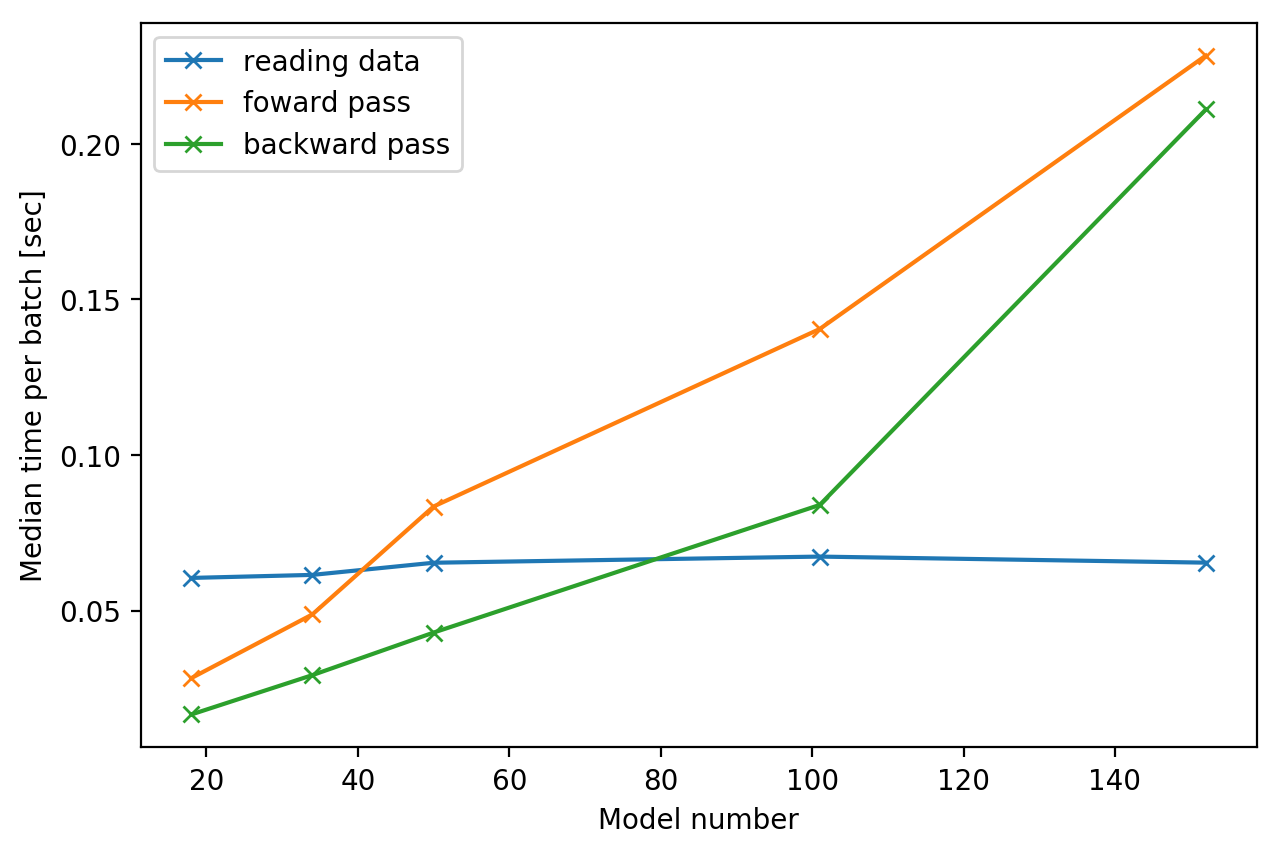

In [71]:
scalar = 1.2
fig = plt.gcf()
fig.set_size_inches(fig.get_size_inches()*scalar)

x_key = sorted(list(data.keys()))
x = [data[key]['model_name'] for key in x_key]

for key in list(data[34]['timing_stats'].keys()):
    if "full" in key or "status" in key:
        continue
    y = [data[model_key]['timing_stats'][key][2] for model_key in x_key]
    plt.plot(x_key, y, 'x-', label=key.split(" per")[0])
    
    #y = [data[model_key]['timing_stats'][key][0] for model_key in x_key]
    #y_err = [data[model_key]['timing_stats'][key][1] for model_key in x_key]
    #plt.errorbar(x_key, y, y_err, fmt='x-', label=key.split(" per")[0])

plt.xlabel("Model number")
plt.ylabel("Median time per batch [sec]")
plt.legend()
plt.show()

## Do Analysis 2

In [79]:
# settings
search_folder = "trained_models/*epochs_60*_misc.pkl"

In [108]:
# Find the models
base_model_paths = glob(search_folder)
to_remove = []
for element in base_model_paths:
    if "scaler_0.001" in element:
        to_remove.append(element)
    if "scaler_0.01" in element:
        to_remove.append(element)
    #if "scaler_0.1" in element:
    #    to_remove.append(element)
    if "scaler_1000.0" in element:
        to_remove.append(element)
    if "scaler_500.0" in element:
        to_remove.append(element)

for to_r in to_remove:
    base_model_paths.remove(to_r)


base_model_paths
for i in range(len(base_model_paths)):
    base_model_paths[i] = base_model_paths[i].split("_misc.")[0]


# read the validation file list
csv_files_dic = {}
ply_files_dic = {}

with open("files_used_in_validation.txt", 'r') as f:
    for line in f:
        if line == '\n' or line == '':
            continue
        line_split = line.split(";")
        name = line_split[1].split("\n")[0]
        key = int(name.split("_nr")[1].split("\\")[0])*10000 + int(name.split("nahme1_")[1].split("_pose")[0])
        csv_files_dic[key] = name
        ply_files_dic[key] = name.split("_pose")[0] + "_cloud0.ply"

sorted_keys = sorted(csv_files_dic.keys())
csv_files = []
ply_files = []
for key in sorted_keys:
    csv_files.append(csv_files_dic[key])
    ply_files.append(ply_files_dic[key])

# Read validation files to memory
quat_gt = read_position_data(csv_files)
compressed_ply = read_ply_data(ply_files)

Reading in pose data. Completed: 100.0[%]
Loading .ply data into compressed memory. Completed: 100.0[%]


In [109]:
square_errors = {}

for mod_i in range(len(base_model_paths)):
    model_base_file_name = base_model_paths[mod_i]
    # load the data from disk
    misc_data, torch_data = read_torch_and_misc_data_from_disk(model_base_file_name)

    # get the model
    # unfortunately this statement dosn't behave as expected within a function,
    # thus it must be executed globally. I know it sucks
    exec("model_fun = resnet."+misc_data['model_name'])

    # now load the model from the state_dict
    model = model_fun(num_classes=num_output_regressors)
    model.load_state_dict(torch_data['model_state_dict'])
    model = model.to(device=device_to_use)

    # get the output scaler
    output_scaler = misc_data['output_scaler']
    
    # get the hyper_scaler from the filename
    # because why would you save that into your misc data?
    # that would have been too easy...
    hyper_scaler = float(model_base_file_name.split("hyper_scaler_")[1].split("_ep")[0])
    
    num_elements = len(compressed_ply)
    
    pos_se = np.zeros((num_elements, 3))
    quat_se = np.zeros((num_elements, 4))

    for ix in range(num_elements):
        # get a .ply file with ground truth
        sample = pose_and_tensor_form_mem(compressed_ply, quat_gt, ix)
        # pretend we had a batch of 1
        sample['image_xyz'] = sample['image_xyz'].reshape([1, *sample['image_xyz'].shape]).to(device=device_to_use)

        # inference results form the model
        pos, quat = inference_image_tensor(sample['image_xyz'], model, output_scaler, normalize_quaternions=True)

        # compare stuff
        pos_se[ix] = np.abs(pos - sample['pose'][:3].numpy()) #** 2
        quat_se[ix] = np.abs(quat - sample['pose'][3:].numpy()) #** 2

        if (ix%print_rate) == 0:
            msg = 'Model {} of {}; Progress: {:.1f}[%]'
            msg = msg.format(mod_i+1, len(base_model_paths), 100*ix/num_elements)
            print(msg, end='\r', flush=True)
    
    
    square_errors[hyper_scaler] = {'pos_se': pos_se, 'quat_se': quat_se}
    msg = 'FINISHED: Model {} of {}                                                   '
    msg = msg.format(mod_i+1, len(base_model_paths))
    print(msg, flush=True)

FINISHED: Model 1 of 9                                                   
FINISHED: Model 2 of 9                                                   
FINISHED: Model 3 of 9                                                   
FINISHED: Model 4 of 9                                                   
FINISHED: Model 5 of 9                                                   
FINISHED: Model 6 of 9                                                   
FINISHED: Model 7 of 9                                                   
FINISHED: Model 8 of 9                                                   
FINISHED: Model 9 of 9                                                   


In [110]:
means = {key: [] for key in square_errors[hyper_scaler].keys()}
stds = {key: [] for key in square_errors[hyper_scaler].keys()}
medians = {key: [] for key in square_errors[hyper_scaler].keys()}

for key in sorted(square_errors.keys()):
    for key2 in square_errors[hyper_scaler].keys():
        means[key2].append(square_errors[key][key2].mean())
        stds[key2].append(square_errors[key][key2].std())
        medians[key2].append(np.median(square_errors[key][key2]))

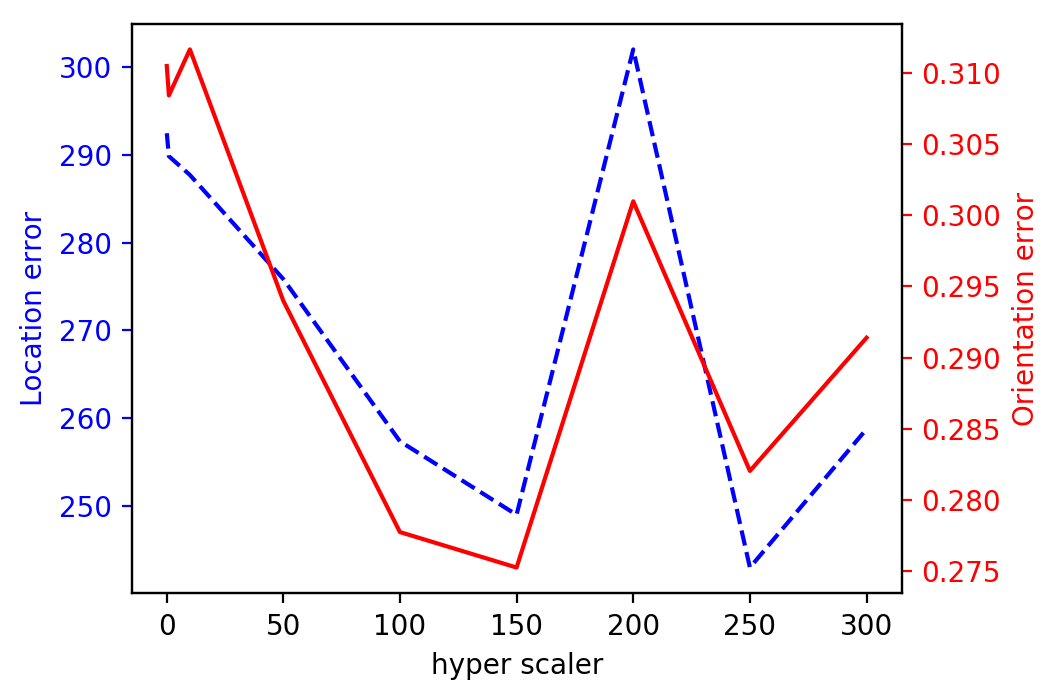

In [111]:
scalar = 0.9
errorbars = False

fig, ax1 = plt.subplots()
fig.set_size_inches(fig.get_size_inches()*scalar)
#ax1.set_xscale("log", nonposx='clip')

t = sorted(square_errors.keys())
if errorbars:
    ax1.errorbar(t, means['pos_se'], stds['pos_se'], fmt='b', label="Location error")
else:
    ax1.plot(t, means['pos_se'], 'b--', label="Location error")
    #ax1.plot(t, medians['pos_se'], 'b')
ax1.set_xlabel('hyper scaler')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Location error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
if errorbars:
    ax2.errorbar(t, means['quat_se'], stds['quat_se'], fmt='r', label="Orientation error")
else:
    ax2.plot(t, means['quat_se'], 'r', label="Orientation error")
ax2.set_ylabel('Orientation error', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

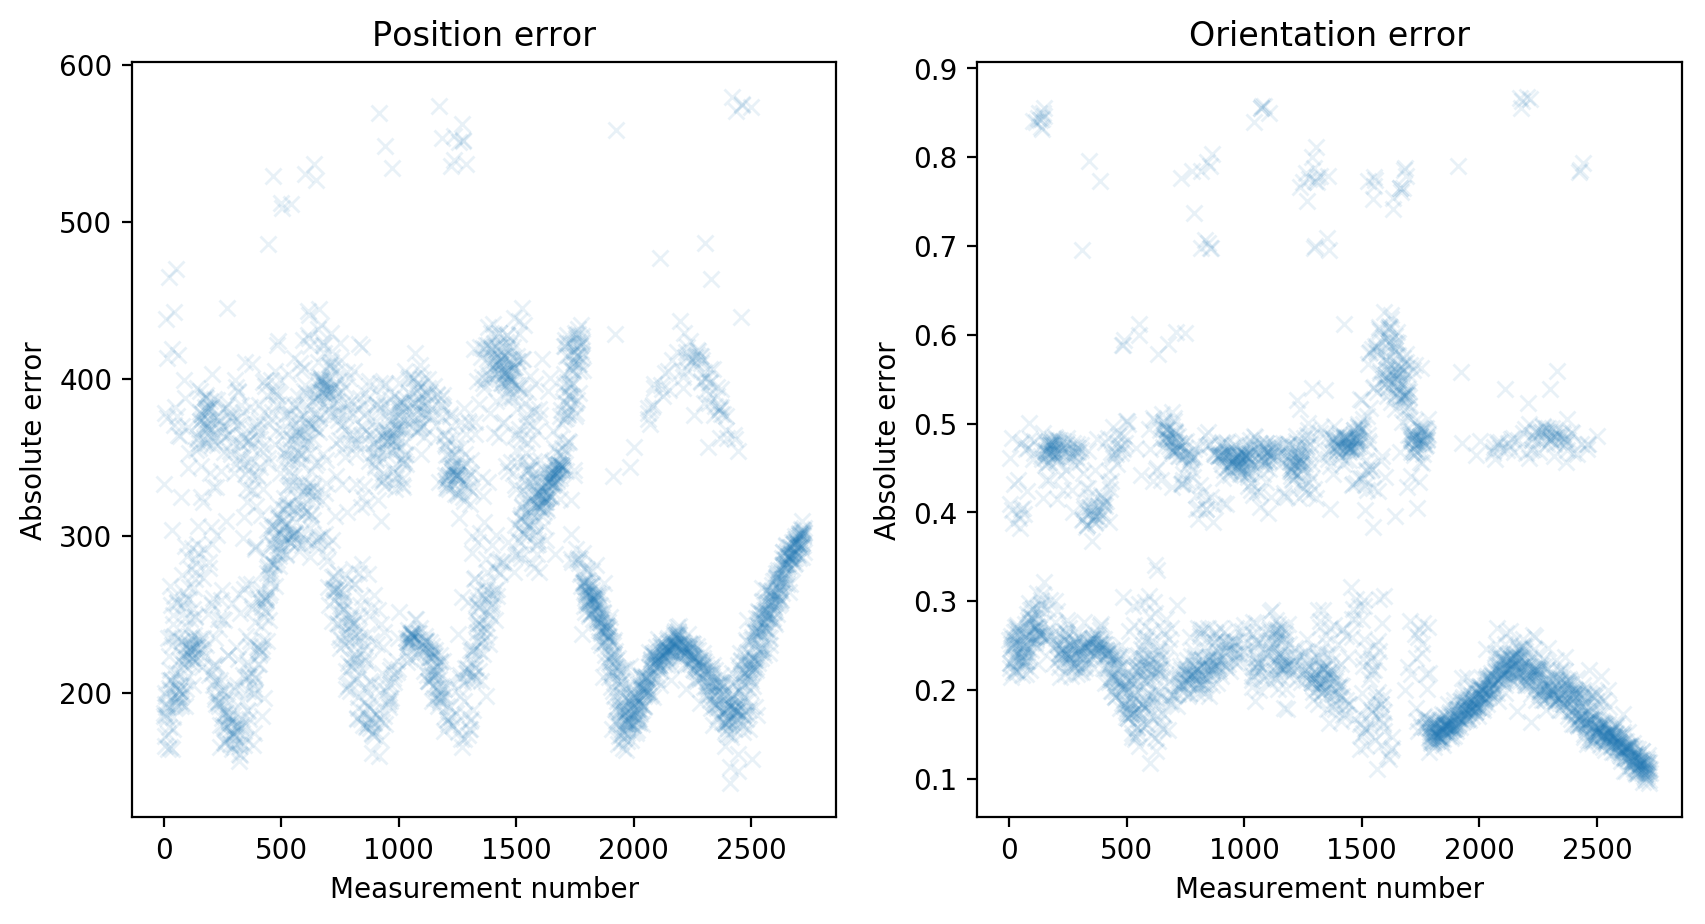

In [112]:
inch_plt = 5
key = 1.0

dat = square_errors[key]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
f.set_size_inches(inch_plt*2, inch_plt)
ax1.plot(dat['pos_se'].mean(axis=1), 'x', alpha=0.1)
ax1.set_title('Position error')
ax2.plot(dat['quat_se'].mean(axis=1), 'x', alpha=0.1)
ax2.set_title('Orientation error')

for ax in (ax1, ax2):
    ax.set_xlabel("Measurement number")
    ax.set_ylabel("Absolute error")

plt.show()

# Loss plotting

In [121]:
# plot the loss evolution of a certian model again

#model_base_file_name = 'trained_models\\corr_loss__1546936554_model_resnet18_optim_SGD_sgd_lr_0.0001_dropout_p_0.5_hyper_scaler_1.0_epochs_60_batches_16'
#model_base_file_name = 'trained_models\\old\\1546417896.9681299_model_resnet18_dropout_p_0.8_hyper_scaler_1_epochs_50_batches_16'
model_base_file_name = 'trained_models\\old\\1546752217.029071_model_resnet18_optim_SGD_sgd_lr_0.0001_dropout_p_0.8_hyper_scaler_1_epochs_200_batches_16'
model_base_file_name = 'trained_models\\old\\1546189617.7519069_model_resnet18_hyper_scaler_1_epochs_50_batches_16'
model_base_file_name = 'trained_models\\old\\1546358280.8201647_model_resnet18_dropout_p_0.5_hyper_scaler_1_epochs_50_batches_16'



# load the data from disk
misc_data, torch_data = read_torch_and_misc_data_from_disk(model_base_file_name)
misc_data['train_loss_evolution'] = np.asarray(misc_data['train_loss_evolution'])
misc_data['val_loss_evolution'] = np.asarray(misc_data['val_loss_evolution'])

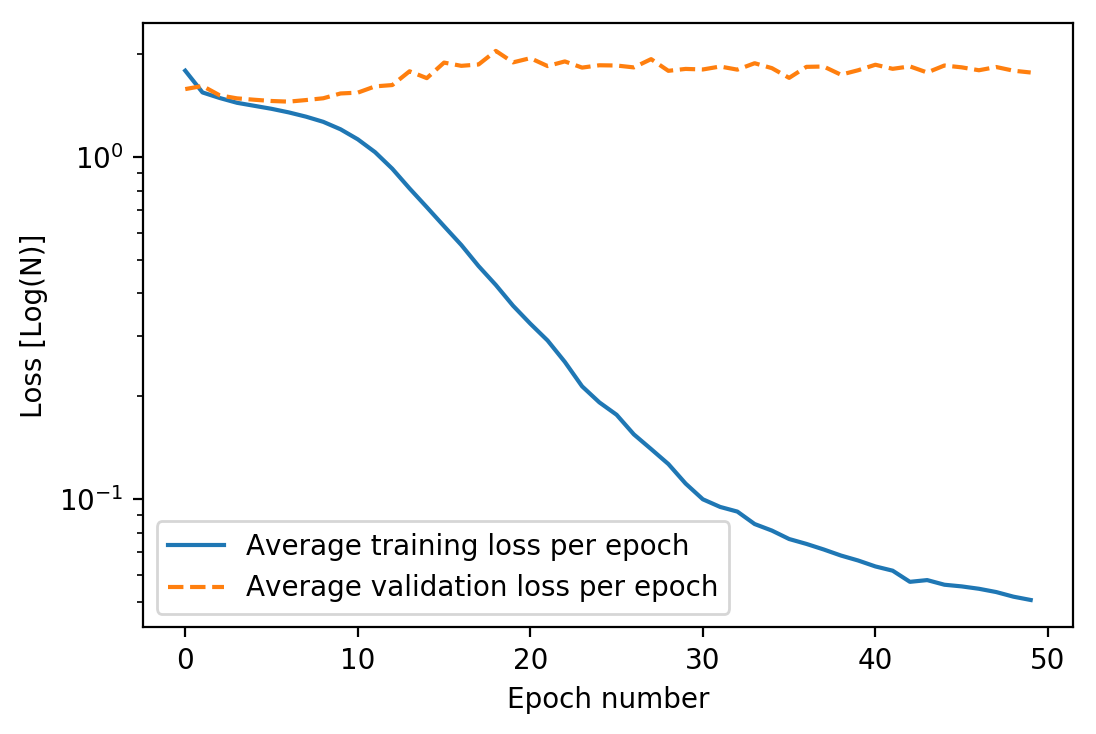

In [122]:
scalar = 0.9


avg_train_loss_per_epoch = misc_data['train_loss_evolution'].sum(axis=1)/misc_data['train_loss_evolution'].shape[1]
avg_val_loss_per_epoch = misc_data['val_loss_evolution'].sum(axis=1)/misc_data['val_loss_evolution'].shape[1]

fig.set_size_inches(fig.get_size_inches()*scalar)
plt.semilogy(np.arange(0, len(avg_train_loss_per_epoch)), avg_train_loss_per_epoch, label="Average training loss per epoch")
plt.semilogy(np.arange(0, len(avg_val_loss_per_epoch)), avg_val_loss_per_epoch, '--', label="Average validation loss per epoch")
plt.xlabel("Epoch number")
plt.ylabel("Loss [Log(N)]")
plt.legend()
#plt.savefig(save_path+"_graph_all_epochs.png", dpi=500)
plt.show()